<a href="https://colab.research.google.com/github/pmopedro/computational-chess/blob/pedro/notebooks/Explore1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
datainfo =  "/content/drive/MyDrive/comp_chess/data/chessData.csv" # proj_folder + 'chessData.csv'
df = pd.read_csv(datainfo)

In [22]:
pip install chess

# Exploratory Data Analysis

In [4]:
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [23]:
def strfix(tr):
    if '#' in str(tr):
        if '-' in tr:
            t = -10000
        else:
            t = 10000
    elif '\ufeff+23' in str(tr):
        t = 0
    else:
        t = int(float(tr))

    t = t/10
    return t

x= df.Evaluation.apply(strfix)

<Axes: ylabel='Density'>

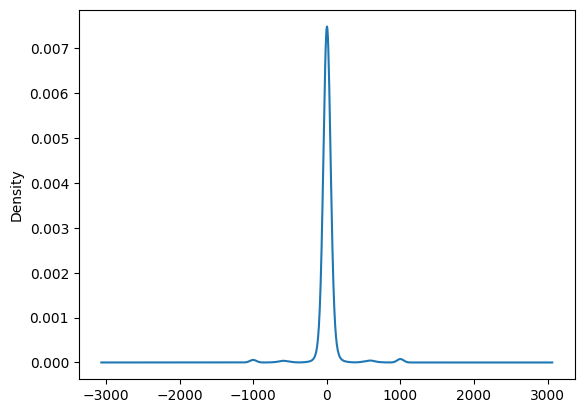

In [10]:
x.plot.kde(bw_method=0.3)

<Axes: ylabel='Density'>

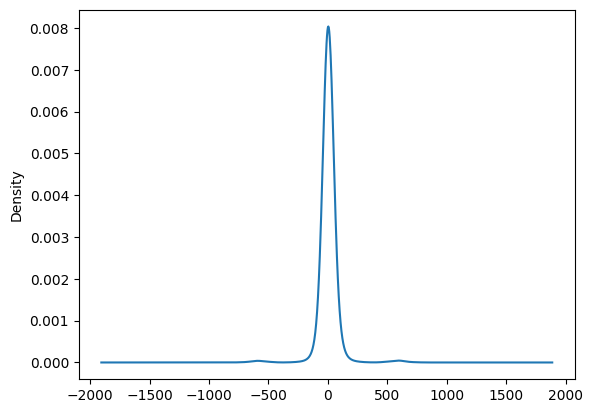

In [18]:
x.loc[(x.values<1000) & (x.values >-1000)].plot.kde(bw_method=0.5)

<Axes: ylabel='Density'>

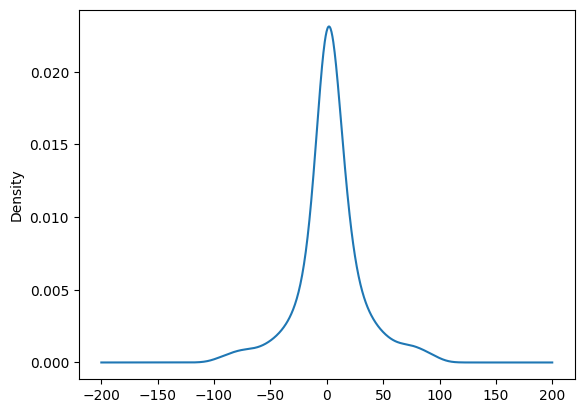

In [19]:
x.loc[(x.values<100) & (x.values >-100)].plot.kde(bw_method=0.3)

# Model Predictions

In [40]:
import chess
def boardstate(fen):
    board = chess.Board(fen)
    fstr = str(fen)

    if board.has_kingside_castling_rights(chess.WHITE) == True:
        WCKI = 1
    else:
        WCKI = 0
    if board.has_queenside_castling_rights(chess.WHITE) == True:
        WCQ = 1
    else:
        WCQ = 0
    if board.is_check() == True:
        WCH = 1
    else:
        WCH = 0

    if board.has_kingside_castling_rights(chess.BLACK) == True:
        BCKI = 1
    else:
        BCKI = 0
    if board.has_queenside_castling_rights(chess.BLACK) == True:
        BCQ = 1
    else:
        BCQ = 0
    if board.was_into_check() == True:
        BCH = 1
    else:
        BCH = 0

    #f = [M, WCKI, WCQ, WCH, BCKI, BCQ, BCH]
    fw = [WCKI, WCQ, WCH]
    fb = [BCKI, BCQ, BCH]

    bstr = str(board)
    bstr = bstr.replace("p", "\ -1")
    bstr = bstr.replace("n", "\ -3")
    bstr = bstr.replace("b", "\ -4")
    bstr = bstr.replace("r", "\ -5")
    bstr = bstr.replace("q", "\ -9")
    bstr = bstr.replace("k", "\ -100")
    bstr = bstr.replace("P", "\ 1")
    bstr = bstr.replace("N", "\ 3")
    bstr = bstr.replace("B", "\ 4")
    bstr = bstr.replace("R", "\ 5")
    bstr = bstr.replace("Q", "\ 9")
    bstr = bstr.replace("K", "\ 100")
    bstr = bstr.replace(".", "\ 0")
    bstr = bstr.replace("\ ", ",")
    bstr = bstr.replace("'", " ")
    bstr = bstr.replace("\n", "")
    bstr = bstr.replace(" ", "")
    bstr = bstr[1:]
    bstr = eval(bstr)
    bstr = list(bstr)
    if "w" not in fstr:
        for i in range(len(bstr)):
            bstr[i] = bstr[i] * -1
        bstr.reverse()
        fs = fb
        fb = fw
        fw = fs


    BITBOARD = fw + fb + bstr


    return BITBOARD


In [25]:
import joblib
model_file = './drive/MyDrive/comp_chess/data/model_V100_7MM.pkl'

model = joblib.load(model_file)

In [42]:
def minimax(position, depth, maximizing_player, evaluate_position):
    print(position.legal_moves)
    if depth == 0 or position.is_game_over():
        return evaluate_position(model, position)

    if maximizing_player:
        max_eval = float('-inf')
        for move in position.legal_moves:
            position.push(move)
            eval_score = minimax(position, depth - 1, False, evaluate_position)
            position.pop()
            max_eval = max(max_eval, eval_score)
        return max_eval
    else:
        min_eval = float('inf')
        for move in position.legal_moves:
            position.push(move)
            eval_score = minimax(position, depth - 1, True, evaluate_position)
            position.pop()
            min_eval = min(min_eval, eval_score)
        return min_eval


def choose_best_move(position, depth):
    best_move = None
    best_eval = float('-inf')
    for move in position.legal_moves:
        position.push(move)
        eval_score = minimax(position, depth - 1, False, evaluate_position)
        position.pop()
        if eval_score > best_eval:
            best_eval = eval_score
            best_move = move
    return best_move


In [88]:
import numpy as np


def evaluate_position(model, test_position):
    input2_columns = [0, 1, 2, 3, 4, 5]

    test_position= boardstate(test_position.fen())

    test_position = pd.DataFrame(test_position).T

    inputboard = test_position.drop(columns=test_position.iloc[:, input2_columns])
    inputboard = np.array(inputboard)
    inputmeta = test_position.iloc[:, input2_columns]
    inputmeta = np.array(inputmeta)
    eval_score = model.predict([(inputboard), (inputmeta)])[0][0]
    return eval_score


In [69]:
import numpy as np

test_example = 'r1b1kbnr/pppN1ppp/4p3/3p2q1/8/2N1P3/PPn2PPP/R1BQKB1R w KQkq - 0 1'
test_position = boardstate(test_example)

input2_columns = [0, 1, 2, 3, 4, 5]

test_position = pd.DataFrame(test_position).T

inputboard = test_position.drop(columns=test_position.iloc[:, input2_columns])
inputboard = np.array(inputboard)
inputmeta = test_position.iloc[:, input2_columns]
inputmeta = np.array(inputmeta)

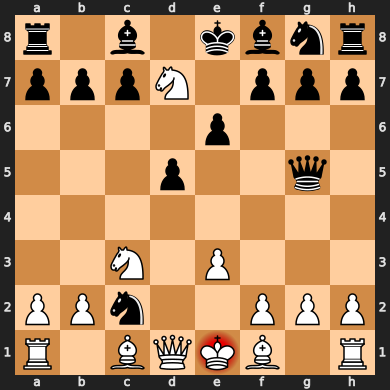

In [87]:
chess.Board(test_example)

In [74]:
test_example = 'r1b1kbnr/pppN1ppp/4p3/3p2q1/8/2N1P3/PPn2PPP/R1BQKB1R w KQkq - 0 1'
a = boardstate(test_example)
evaluate_position(model, a)

1/1 [==============================] - 0s 38ms/step


4.6247096

In [92]:
a = boardstate(test_example)
x = chess.Board(test_example)
best_move = choose_best_move(x, depth=1)
print("Best Move :", best_move)

1/1 [==============================] - 0s 92ms/step
Best Move : e1e2


In [91]:
a = boardstate(test_example)
x = chess.Board(test_example)
best_move = choose_best_move(x, depth=2)
print("Best Move :", best_move)

1/1 [==============================] - 0s 25ms/step
Best Move : d1c2


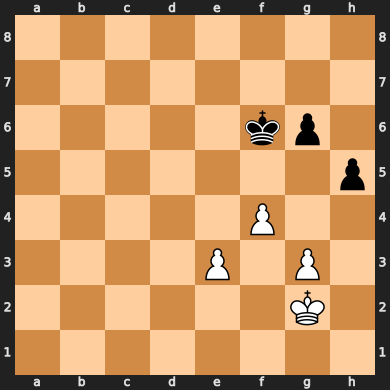

In [126]:
test_example = '8/8/5kp1/7p/5P2/4P1P1/6K1/8 w - - 0 1'
chess.Board(test_example)

In [127]:
evaluate_position(model, chess.Board(test_example))

1/1 [==============================] - 0s 31ms/step


15.511635

In [128]:
a = boardstate(test_example)
x = chess.Board(test_example)
best_move = choose_best_move(x, depth=2)
print("Best Move :", best_move)

1/1 [==============================] - 0s 32ms/step
Best Move : g2f3
